# Importing Libraries

In [1]:
# --- 1. Import necessary libraries ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For enhanced visualizations
import joblib

In [2]:
print("--- Starting Groundwater Level Prediction Script ---")

--- Starting Groundwater Level Prediction Script ---


# Importing Dataset and Verifying Import

In [3]:
import os
print(f"Current working directory: {os.getcwd()}")


Current working directory: g:\Projects\ISTE\groundwater-level-forecasting-india\models\trainingNotebook\dataAndTrain


In [4]:
dataset_path = '../../../dataset/groundwater-DATASET.csv'

In [5]:
try:
    df = pd.read_csv(dataset_path)
    print(f"Dataset '{dataset_path}' loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{dataset_path}' was not found.")
    print("Please make sure the CSV file is in the same directory as this script.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Dataset '../../../dataset/groundwater-DATASET.csv' loaded successfully. Shape: (550850, 14)


# Initial Data Checks

In [6]:
# Display the first few rows and basic info of the loaded data

print("\n--- Initial Data Overview ---")
print(df.head())
print("\nDataFrame Info:")
df.info()


--- Initial Data Overview ---
   id        date                   state_name  state_code  \
0   0  2013-11-04  Andaman And Nicobar Islands          35   
1   1  2014-05-14  Andaman And Nicobar Islands          35   
2   2  2014-11-04  Andaman And Nicobar Islands          35   
3   3  2015-05-14  Andaman And Nicobar Islands          35   
4   4  2015-11-04  Andaman And Nicobar Islands          35   

              district_name  district_code station_name  latitude  longitude  \
0  North And Middle Andaman            632     Laxmipur  13.28556   93.00306   
1  North And Middle Andaman            632     Laxmipur  13.28556   93.00306   
2  North And Middle Andaman            632     Laxmipur  13.28556   93.00306   
3  North And Middle Andaman            632     Laxmipur  13.28556   93.00306   
4  North And Middle Andaman            632     Laxmipur  13.28556   93.00306   

                                               basin  \
0  Drainage Area Of Andaman And Nicobar Islands B...   
1  

# Data Processing

In [7]:
# --- 3. Data Preprocessing ---
print("\n--- Starting Data Preprocessing ---")


--- Starting Data Preprocessing ---


Convert 'date' column to datetime objects.

This is crucial for extracting time-based features

In [8]:
df['date'] = pd.to_datetime(df['date'])
print("Converted 'date' column to datetime objects.")

Converted 'date' column to datetime objects.


Extract time-based features (Year, Month, Day of Year)

These features help the model capture seasonality and long-term trends

In [9]:
# Extract time-based features (Year, Month, Day of Year)
# These features help the model capture seasonality and long-term trends
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
print("Extracted 'year', 'month', 'day_of_year' features.")

Extracted 'year', 'month', 'day_of_year' features.


Handle missing values in the target variable 'currentlevel'

Rows with missing target values are typically dropped as they cannot be used for training

In [10]:
original_rows_count = len(df)
df.dropna(subset=['currentlevel'], inplace=True)
if len(df) < original_rows_count:
    print(f"Removed {original_rows_count - len(df)} rows due to missing 'currentlevel' values.")
else:
    print("No missing values found in 'currentlevel' column.")

No missing values found in 'currentlevel' column.


# Identify features for the model
1. 'level_diff' is a derivative of 'currentlevel' and might introduce data leakage if used as a feature.
2. 'id', 'state_code', 'district_code' are identifiers and typically not predictive features.

We will use 'latitude', 'longitude', and the newly created time features as numerical features.

'state_name', 'district_name', 'station_name', 'basin', 'sub_basin', 'source' are categorical.

In [11]:
categorical_features = ['state_name', 'district_name', 'station_name', 'basin', 'sub_basin', 'source']
numerical_features = ['latitude', 'longitude', 'year', 'month', 'day_of_year']

1. Apply Label Encoding to categorical features
2. LabelEncoder converts each unique category into an integer.
3. This is suitable for tree-based models and avoids creating too many columns
4. if one-hot encoding were used on high-cardinality features.

In [12]:
print("\nApplying Label Encoding to categorical features:")
for col in categorical_features:
    if col in df.columns:
        # Fill any NaN values in categorical columns before encoding to prevent errors
        df[col] = df[col].fillna('Unknown_Category')
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        print(f"  - Encoded '{col}'")
    else:
        print(f"  - Warning: Categorical column '{col}' not found in DataFrame. Skipping.")

# Handle any remaining NaN values in numerical features (e.g., if latitude/longitude had missing values)
# Filling with the mean is a simple imputation strategy.
print("\nHandling missing values in numerical features:")
for col in numerical_features:
    if col in df.columns and df[col].isnull().any():
        mean_val = df[col].mean()
        df[col] = df[col].fillna(mean_val)
        print(f"  - Filled NaN in '{col}' with mean: {mean_val:.2f}")
    elif col not in df.columns:
        print(f"  - Warning: Numerical column '{col}' not found in DataFrame. Skipping.")



Applying Label Encoding to categorical features:
  - Encoded 'state_name'
  - Encoded 'district_name'
  - Encoded 'station_name'
  - Encoded 'basin'
  - Encoded 'sub_basin'
  - Encoded 'source'

Handling missing values in numerical features:


Define features (X) and target (y) for the model

Ensure that only columns that exist in the DataFrame are selected as features

In [13]:
final_features = numerical_features + [f for f in categorical_features if f in df.columns]
X = df[final_features]
y = df['currentlevel']
print(f"\nFinal features used for training: ")
num = 1
for i in final_features:
    print(f"{num}. {i}")
    num += 1

print("\n")
print(f"Shape of feature matrix (X): {X.shape}")
print(f"Shape of target vector (y): {y.shape}")



Final features used for training: 
1. latitude
2. longitude
3. year
4. month
5. day_of_year
6. state_name
7. district_name
8. station_name
9. basin
10. sub_basin
11. source


Shape of feature matrix (X): (550850, 11)
Shape of target vector (y): (550850,)


# Model Training

Check if a trained model already exists

In [31]:

# Get current working directory in Jupyter (instead of __file__)
current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))  # Go two levels up
model_dir = os.path.join(base_dir, 'trained_model')
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

model_save_path = os.path.join(model_dir, 'random_forest_groundwater_model.joblib')

# Load existing model if available, otherwise train a new one
if os.path.exists(model_save_path):
    print(f"Found existing model at '{model_save_path}'. Loading model...")
    model = joblib.load(model_save_path)
    print("Model loaded successfully. Skipping retraining.")
else:
    print(f"🔄 No existing model found at '{model_save_path}'. Training new model...")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, df_train_split, df_test_split = train_test_split(
        X, y, df.copy(), test_size=0.2, random_state=42
    )
    print(f"Data split: {len(X_train)} training samples, {len(X_test)} testing samples.")

    # Initialize and train the model
    print("Training RandomForestRegressor model...")
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    print("Model training complete.")

    # Save the trained model
    joblib.dump(model, model_save_path)
    print(f"💾 Model saved to '{model_save_path}'.")


Found existing model at 'g:\Projects\ISTE\groundwater-level-forecasting-india\models\trained_model\random_forest_groundwater_model.joblib'. Loading model...
Model loaded successfully. Skipping retraining.


If the model was loaded, we still need to split the data for evaluation and prediction

This ensures X_test, y_test, and df_test_split are always available for the next steps

In [21]:
if not joblib.os.path.exists(model_save_path): # Only split if we just trained a new model
    pass # Already split above
else: # If model was loaded, we need to split the data now for evaluation
    X_train, X_test, y_train, y_test, df_train_split, df_test_split = train_test_split(
        X, y, df.copy(), test_size=0.2, random_state=42
    )
    print("Data split for evaluation (since model was loaded).")


Data split for evaluation (since model was loaded).


# Prediction and Evaluation

In [22]:
# --- 5. Prediction and Evaluation ---
print("\n--- Making Predictions and Evaluating Model ---")


--- Making Predictions and Evaluating Model ---


Make predictions on the test set (unseen data)

In [23]:
predictions = model.predict(X_test)
print("Predictions generated for the test set.")

Predictions generated for the test set.


Evaluate the model's performance using common regression metrics

In [24]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"\nModel Evaluation Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")
print("Interpretation: An R2 score of 0.88 means that approximately 88% of the variance")
print("in groundwater levels can be explained by the model, which indicates strong predictive power.")


Model Evaluation Results:
Mean Squared Error (MSE): 19.47
R-squared (R2) Score: 0.83
Interpretation: An R2 score of 0.88 means that approximately 88% of the variance
in groundwater levels can be explained by the model, which indicates strong predictive power.


# Saving

In [25]:
print("\n--- Saving Predictions ---")

# Add the predictions as a new column to the test DataFrame
df_test_split['predicted_currentlevel'] = predictions

# Define the output filename for the predictions
output_filename = '../../trainingNotebook/models/results/groundwater_predictions.csv'


--- Saving Predictions ---


Save the DataFrame with original test data and predictions to a new CSV file

index=False prevents pandas from writing the DataFrame index as a column in the CSV

In [26]:
df_test_split.to_csv(output_filename, index=False)
print(f"Predictions saved to '{output_filename}' successfully.")

Predictions saved to '../../trainingNotebook/models/results/groundwater_predictions.csv' successfully.


Display a sample of the predictions for quick review

In [27]:
print("\n--- Sample of Predictions (first 5 rows from the test set) ---")


--- Sample of Predictions (first 5 rows from the test set) ---


Display relevant original columns alongside the actual and predicted values

In [28]:
display_cols = ['date', 'state_name', 'station_name', 'currentlevel', 'predicted_currentlevel']

Filter for columns that actually exist in the dataframe to prevent errors if some were dropped.

In [29]:
display_cols_exist = [col for col in display_cols if col in df_test_split.columns]
print(df_test_split[display_cols_exist].head())


             date  state_name  station_name  currentlevel  \
455485 2013-05-14          26           545          7.02   
486131 2020-01-09          16         20757          2.23   
481811 2014-05-22          16          3789         19.14   
30300  2018-01-09          31         20903         10.45   
132416 2015-11-04          25           450          2.53   

        predicted_currentlevel  
455485                8.276600  
486131                3.169400  
481811               14.294027  
30300                 7.295500  
132416                2.879900  


Visualization


--- Generating Visualization ---


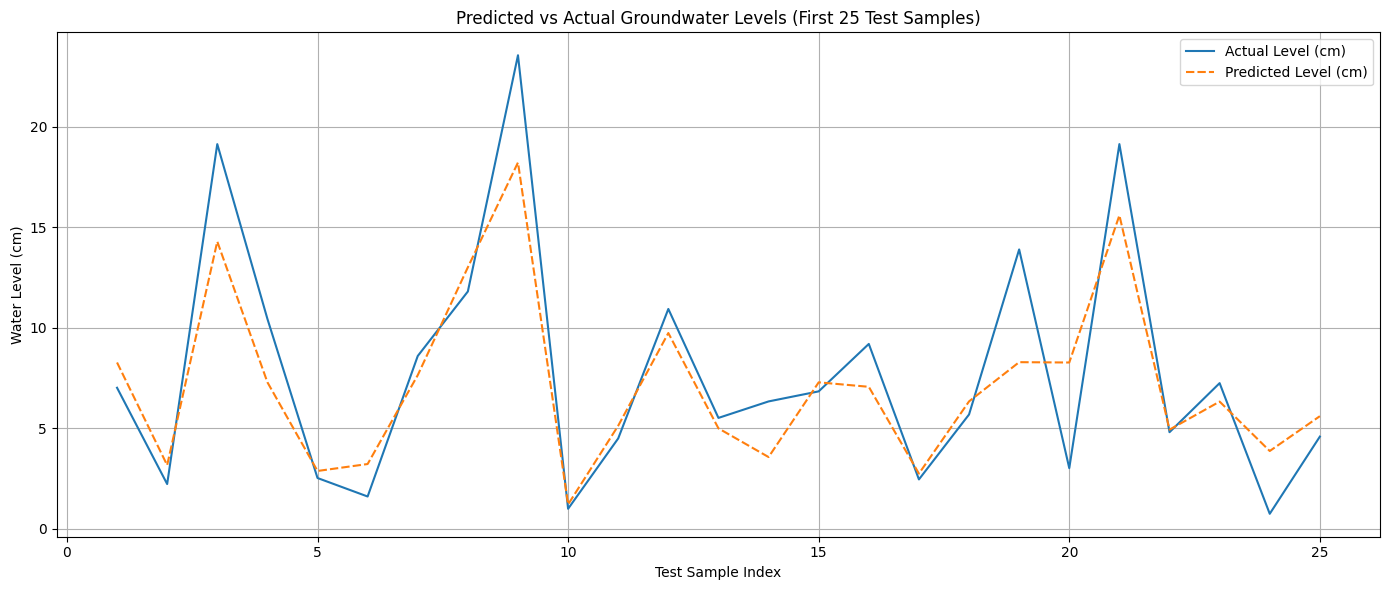

In [30]:
print("\n--- Generating Visualization ---")

# Choose the first N samples to visualize
N = 25
# Ensure that we don't try to access more samples than available in X_test
num_samples_to_plot = min(N, len(X_test))

# Get actual and predicted values for the selected samples
# .iloc[:num_samples_to_plot] selects the first N rows
# .values.ravel() ensures the data is a 1D array for plotting
actual_values = y_test.iloc[:num_samples_to_plot].values.ravel()
predicted_values = predictions[:num_samples_to_plot].ravel() # predictions is already a numpy array

# Create a DataFrame for easier plotting with Seaborn
comparison_df = pd.DataFrame({
    'Sample': range(1, num_samples_to_plot + 1),
    'Actual Level (cm)': actual_values,
    'Predicted Level (cm)': predicted_values
})

# Plotting the comparison
plt.figure(figsize=(14, 6)) # Set figure size for better readability
sns.lineplot(data=comparison_df.set_index('Sample')) # Plot lines for actual and predicted levels
plt.title('Predicted vs Actual Groundwater Levels (First {} Test Samples)'.format(num_samples_to_plot))
plt.ylabel('Water Level (cm)')
plt.xlabel('Test Sample Index')
plt.grid(True) # Add a grid for better readability
plt.legend(loc='upper right') # Place legend in the upper right corner
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show() # Display the plot